<a href="https://colab.research.google.com/github/shaanbarca/datascience_portfolio/blob/main/future_monthly_final_prophet_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 import pandas as pd
from fbprophet import Prophet

In [ ]:
!pip install fbprophet

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
register_matplotlib_converters()
from time import time

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving daily_query.csv to daily_query.csv


In [ ]:
def parser(s):
  return datetime.strptime(s, '%Y-%m-%d')

In [ ]:
df = pd.read_csv('daily_query.csv',parse_dates=[0],index_col=0,squeeze=True, date_parser=parser)

In [ ]:
df.head()

,Berthing,StartWork,EndWork,Departure,nama_kapal,voyage,bendera,dwt,gt,loa,asal,tujuan,dermaga,bongkar,teus_bongkar,20 Empty Bongkar,40 Empty Bongkar,20 Full Bongkar,40 Full Bongkar,tonase_bongkar,muat,teus_muat,20 Empty Muat,40 Empty Muat,20 Full Muat,40 Full Muat,tonase_muat,total_shifting,QuayCode
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-03-30,29/3/2016 10:50:21,29/3/2016 11:52:53,30/3/2016 11:30:46,30/3/2016 12:15:55,YM IMAGE,065S / 065N,YANG MING LINE,22027,16488,173,PORT KLANG2,PEL JAKARTA,TER3,0,0,0,0,0,0,0.0,1,2,0,1,0,0,395000,0,TER3
2016-05-11,10/5/2016 22:05:08,10/5/2016 22:47:11,11/5/2016 16:00:47,11/5/2016 19:00:07,YM IMAGE,068S / 068N,YANG MING LINE,22027,16488,173,"PEL PORT KLANG, MALAYSIA",PEL JAKARTA,TER3,1,2,0,0,0,1,2880000.0,0,0,0,0,0,0,0,0,TER3
2016-06-23,21/6/2016 20:14:49,21/6/2016 21:00:56,23/6/2016 01:40:22,23/6/2016 02:30:36,YM IMAGE,071S / 071N,YANG MING LINE,22027,16488,173,"PEL PORT KLANG, MALAYSIA",PEL JAKARTA,TER3,0,0,0,0,0,0,0.0,1,2,0,0,0,1,2813200,0,TER3
2016-07-15,14/7/2016 15:30:08,14/7/2016 16:30:00,15/7/2016 18:40:09,15/7/2016 19:15:28,BALTIC STRAIT,054S / 054N,YANG MING LINE,23840,18102,183,PEL SINGAPORE,PEL JAKARTA,TER3,1,2,0,0,0,1,2810000.0,0,0,0,0,0,0,0,0,TER3
2017-01-01,31/12/2016 16:00:02,31/12/2016 16:58:00,1/1/2017 21:55:33,1/1/2017 23:30:02,NYK DANIELLA,021S / 022N,SAMUDERA SHIPPING LINE,34536,27051,210,PEL SINGAPORE,PEL JAKARTA,TER3,0,0,0,0,0,0,0.0,9,14,0,0,4,5,113827,0,TER3


In [ ]:
sum_teus = df['teus_bongkar'] + df['teus_muat']

In [ ]:
df['total_teus'] = sum_teus

In [ ]:
df = df[['total_teus']]

In [ ]:
start_date = pd.to_datetime('2017-01-01')

In [ ]:
df = df[start_date:]

In [ ]:
df.head()

,total_teus
date,
2017-01-01,14
2017-01-02,21
2017-01-05,102
2017-01-06,108
2017-01-08,558


In [ ]:
df['ds'] = df.index


In [ ]:
df1 = df.groupby(pd.Grouper(freq='M', key='ds'))['total_teus'].sum()

In [ ]:
df1.head()

ds
2017-01-31    23441
2017-02-28    23097
2017-03-31    29737
2017-04-30    24550
2017-05-31    29506
Freq: M, Name: total_teus, dtype: int64

In [ ]:
df1.shape

(52,)

In [ ]:
new_df = df1.to_frame()

In [ ]:
new_df.head()

,total_teus
ds,
2017-01-31,23441
2017-02-28,23097
2017-03-31,29737
2017-04-30,24550
2017-05-31,29506


In [ ]:
new_df['ds'] = new_df.index


In [ ]:
new_df.columns

Index(['total_teus', 'ds'], dtype='object')

In [ ]:
new_df.columns

Index(['total_teus', 'ds'], dtype='object')

In [ ]:
new_df.columns = ['y', 'ds']

In [ ]:
new_df.head()

,y,ds
ds,,
2017-01-31,23441,2017-01-31
2017-02-28,23097,2017-02-28
2017-03-31,29737,2017-03-31
2017-04-30,24550,2017-04-30
2017-05-31,29506,2017-05-31


In [ ]:
sns.set(rc={'figure.figsize':(20.7,5.27)})

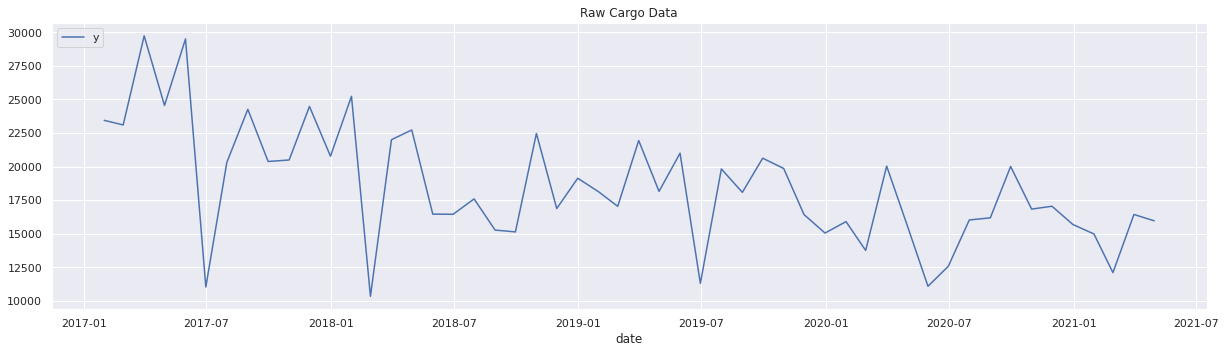

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(x='ds', y='y', label='y', data=new_df, ax=ax)
ax.legend(loc='upper left')
ax.set(title='Raw Cargo Data', xlabel='date', ylabel='');

####Splitting the data

In [ ]:
threshold_date = pd.to_datetime('2021-01-01')
mask = new_df['ds'] < threshold_date

In [ ]:
df_train = new_df[mask][['y', 'ds']]
df_test = new_df[~ mask][['y', 'ds']]

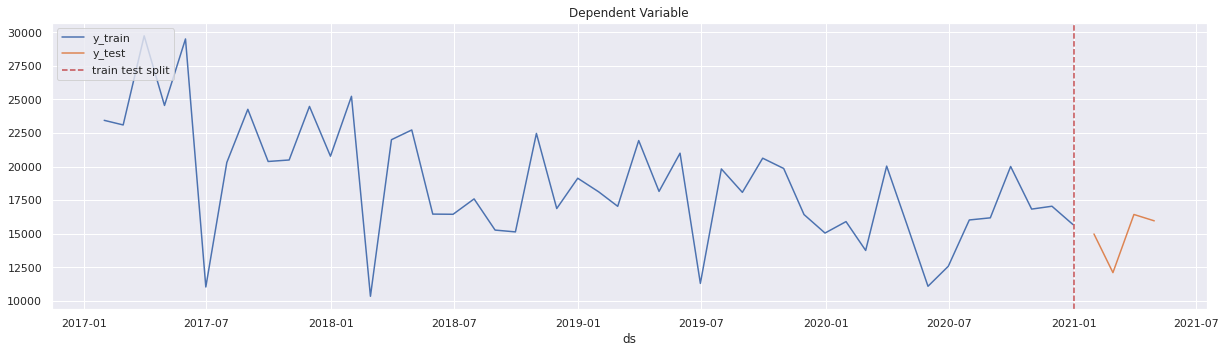

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(x='ds', y='y', label='y_train', data=df_train, ax=ax)
sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='Dependent Variable', ylabel='');

In [ ]:
def build_model():
    """Define forecasting model."""
    
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,  
        interval_width=0.95, 
        mcmc_samples = 500
    )

    # model.add_seasonality(
    #     name='monthly', 
    #     period=30.5, 
    #     fourier_order=5
    # )

    # model.add_seasonality(
    #     name='weekly',
    #     period=7,
    #     fourier_order=10
    # )


    model.add_country_holidays(country_name='ID')

    
    return model
    
model = build_model()

In [ ]:
model.fit(df_train)

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019



In [ ]:
print(model.train_holiday_names)


0               New Year's Day
1             Chinese New Year
2        Day of Silence/ Nyepi
3     Ascension of the Prophet
4                    Labor Day
5           Ascension of Jesus
6            Buddha's Birthday
7                Pancasila Day
8                  Eid al-Fitr
9             Independence Day
10      Feast of the Sacrifice
11            Islamic New Year
12        Birth of the Prophet
13                   Christmas
dtype: object


In [ ]:
# Extend dates and features. 
future = model.make_future_dataframe(periods=10, freq='M')
# Generate predictions. 
forecast = model.predict(df=future)

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019



In [ ]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Ascension of Jesus,Ascension of Jesus_lower,Ascension of Jesus_upper,Ascension of the Prophet,Ascension of the Prophet_lower,Ascension of the Prophet_upper,Birth of the Prophet,Birth of the Prophet_lower,Birth of the Prophet_upper,Buddha's Birthday,Buddha's Birthday_lower,Buddha's Birthday_upper,Chinese New Year,Chinese New Year_lower,Chinese New Year_upper,Christmas,Christmas_lower,Christmas_upper,Day of Silence/ Nyepi,Day of Silence/ Nyepi_lower,Day of Silence/ Nyepi_upper,Eid al-Fitr,Eid al-Fitr_lower,Eid al-Fitr_upper,Feast of the Sacrifice,Feast of the Sacrifice_lower,Feast of the Sacrifice_upper,Independence Day,Independence Day_lower,Independence Day_upper,Islamic New Year,Islamic New Year_lower,Islamic New Year_upper,Labor Day,Labor Day_lower,Labor Day_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,Pancasila Day,Pancasila Day_lower,Pancasila Day_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
53,2021-06-30,14885.343734,-399.162261,17823.094382,10884.482054,18636.297151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6044.753924,-10280.681430,-1947.846719,0.0,0.0,0.0,-6044.753924,-10280.681430,-1947.846719,0.0,0.0,0.0,8840.589810
54,2021-07-31,14767.247737,4391.725488,23544.267087,10593.319804,18661.057363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-703.251738,-4957.177363,3791.449521,0.0,0.0,0.0,-703.251738,-4957.177363,3791.449521,0.0,0.0,0.0,14063.995999
55,2021-08-31,14649.151739,4871.326864,24723.758897,10340.891007,18698.177141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,217.106431,-4232.406380,4365.588777,0.0,0.0,0.0,217.106431,-4232.406380,4365.588777,0.0,0.0,0.0,14866.258170
56,2021-09-30,14534.865290,5784.617894,24010.316073,9993.278184,18791.465570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,781.345530,-3194.203837,4800.649455,0.0,0.0,0.0,781.345530,-3194.203837,4800.649455,0.0,0.0,0.0,15316.210819
57,2021-10-31,14416.769292,5718.889083,24370.111514,9672.757471,18841.917138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,873.560390,-3363.673502,5049.673489,0.0,0.0,0.0,873.560390,-3363.673502,5049.673489,0.0,0.0,0.0,15290.329683


In [ ]:
mask2 = forecast['ds'] < threshold_date

forecast_train = forecast[mask2]
forecast_test = forecast[~ mask2]

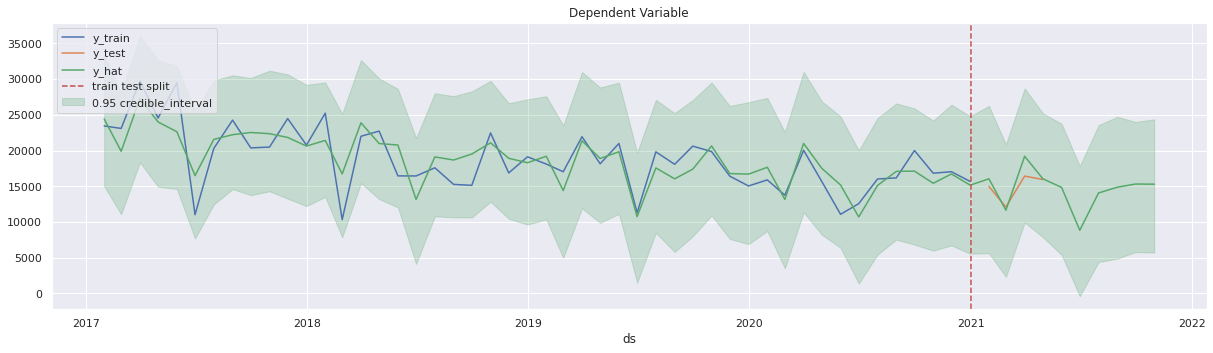

In [ ]:
fig, ax = plt.subplots()
ax.fill_between(
    x=forecast['ds'],
    y1=forecast['yhat_lower'],
    y2=forecast['yhat_upper'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_train', data=df_train, ax=ax)
sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast, ax=ax)
ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='Dependent Variable', ylabel='');


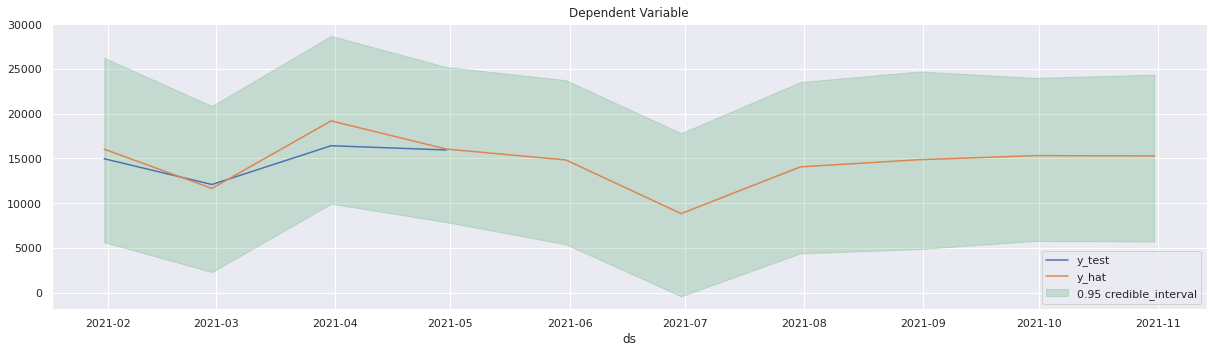

In [ ]:
fig, ax = plt.subplots()

ax.fill_between(
    x=forecast_test['ds'],
    y1=forecast_test['yhat_lower'],
    y2=forecast_test['yhat_upper'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)
sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast_test, ax=ax)
ax.legend(loc='lower right')
ax.set(title='Dependent Variable', ylabel='');

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error
print('r2: {}'.format(r2_score(y_true=df_train['y'], y_pred=forecast_train['yhat'])))
print('---'*10)
print('mae train: {}'.format(mean_absolute_error(y_true=df_train['y'], y_pred=forecast_train['yhat'])))
print('mae test: {}'.format(mean_absolute_error(y_true=df_test['y'], y_pred=forecast_test['yhat'])))

r2: 0.6483060433631518
------------------------------
mae train: 2080.3897850443536
mae test: 1211.4259170958944
